# Title

This Notebook...

## Initialization

### Imports

In [1]:
import sys
import datetime
import csv
import time as timeModule
import numpy
import scipy
import scipy.ndimage
import scipy.ndimage.measurements
import scipy.ndimage.filters
import skimage
import skimage.measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

### Helper Functions

In [2]:
debugMode = True;

In [3]:
def dprint(objectToPrint, depth = 0):
    indent = "  " * depth
    if (debugMode):
        print(indent + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) + " | " + str(objectToPrint))

In [4]:
def progressBar(message, value, endvalue, bar_length = 20):
    if debugMode:
        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))
        sys.stdout.write("\r" 
                         + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) 
                         + " | " 
                         + message 
                         + ": [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        if value == endvalue:
            sys.stdout.write("\n")
        sys.stdout.flush()

In [5]:
def extractAttribute(bpsCode, startBit, endBit):
    return int(bpsCode, 16) >> (80 - endBit) & int("1" * (endBit - startBit), 2)

In [6]:
print(extractAttribute("00D00C03405B18200005", 14, 24))
print(extractAttribute("00D00C03405B18200005", 24, 38))

12
208


## Classes

In [7]:
class BPSDetector:
    bpsCode = None
    roadNumber = None
    hectometer = None
    additionalMeters = None
    def __init__(self, bpsCode):
        self.bpsCode = bpsCode
        self.roadNumber = extractAttribute(bpsCode, 14, 24)
        self.hectometer = extractAttribute(bpsCode, 24, 38)
        self.additionalMeters = extractAttribute(bpsCode, 38, 48)
    def getBPSCoder(self):
        return self.bpsCode
    def getRoadNumber(self):
        return self.roadNumber
    def getMeter(self):
        return 100 * self.hectometer + self.additionalMeters
    def __str__(self):
        return "bpsCode: {} | roadNumber: {} | hectometer: {} | additionalMeters: {}".format(self.bpsCode, self.roadNumber, self.hectometer, self.additionalMeters)

In [8]:
bpsDetector = BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


In [9]:
class Road:
    roadNumber = None
    bpsDetectors = None
    spaceToSpaceIndex = None
    def __init__(self, roadNumber):
        self.roadNumber = roadNumber
        self.bpsDetectors = set()
        self.spaceToSpaceIndex = dict()
    def addBPSDetector(self, bpsDetector):
        self.bpsDetectors.add(bpsDetector)
    def indexDetectorSpaces(self):
        spaceSet = set()
        for bpsDetector in self.bpsDetectors:
            spaceSet.add(bpsDetector.getMeter())
        sortedSpaceSet = sorted(spaceSet)
        for spaceIndex in range(len(sortedSpaceSet)):
            self.spaceToSpaceIndex[sortedSpaceSet[spaceIndex]] = spaceIndex
    def getBPSDetectors(self):
        return self.bpsDetectors
    def getSpaceToSpaceIndex(self):
        return self.spaceToSpaceIndex
    def __str__(self):
        return "roadNumber: {} | len(bpsDetectors): {} | len(spaceToSpaceIndex): {}".format(self.roadNumber, len(self.bpsDetectors), len(self.spaceToSpaceIndex))

In [41]:
road = Road(15)
road.addBPSDetector(bpsDetector)
print(road)
road.indexDetectorSpaces()
print(road.getSpaceToSpaceIndex())

roadNumber: 15 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 0
{20891: 0}


In [11]:
class Detection:
    code = None
    space = None
    time = None
    speed = None
    flow = None
    def __init__(self, code, space, time, speed, flow):
        self.code = code
        self.space = space
        self.time = time
        self.speed = speed
        self.flow = flow
    def getCode(self):
        return self.code
    def getSpace(self):
        return self.space
    def getTime(self):
        return self.time
    def getSpeed(self):
        return self.speed
    def getFlow(self):
        return self.flow
    def __str__(self):
        return "code: {} | space: {} | time: {} | speed: {} | flow: {}".format(self.code, self.space, self.time, self.speed, self.flow)

## Roads

In [12]:
def readCSVToBPSCodes(fileName):
    dprint("Starting readCSVToBPSCodes()")
    result = []
    with open(fileName, "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[3] == "R":
                result.append(row[0])
    dprint("Ending readCSVToBPSCodes()")
    return result

In [13]:
bpsCodes = readCSVToBPSCodes("Test_Data\BPS_20171120.csv")

2017-11-29 10:59:11 | Starting readCSVToBPSCodes()
2017-11-29 10:59:11 | Ending readCSVToBPSCodes()


In [14]:
for bpsCode in bpsCodes:
    print(bpsCode)

10D00100A055D0070007
10D00100A055D007000B
10D00100A055D007000F
10D00100B85ED0070007
10D00100B85ED007000B
10D00100B85ED007000F
10D00100D05CD0070007
10D00100D05CD007000B
10D00100D05CD007000F
10D00100D05CD0070013
10D00100D05CD0070017
10D00100DC02D0070007
10D00100DC02D007000B
10D00100DC02D007000F
10D00100DC02D0070013
10D00100DC02D0070017
10D00100F41AD0070007
10D00100F41AD007000B
10D00100F41AD007000F
10D00100F41AD0070013
10D001010049D0070007
10D001010049D007000B
10D001010049D007000F
10D001010049D0070013
10D001011805D0070007
10D001011805D007000B
10D001011805D007000F
10D001011805D0070013
10D001011C62D007000B
10D001011C62D007000F
10D001011C62D0070013
10D001011C62D0070017
10D001012C00D0070007
10D001012C00D007000B
10D001012C00D007000F
10D001012C00D0070013
10D001012C00D0070307
10D001012C00D007030B
10D001013800D0070007
10D001013800D007000B
10D001013800D007000F
10D001013800D0070013
10D001013800D0070307
10D001013800D007030B
10D001014063D0070007
10D001014063D007000B
10D001014063D007000F
10D001014063D

10D00118BC5FD007000B
10D00204D037D0070007
10D00204D037D007000B
10D00204D037D0070307
10D00204D85AD0070007
10D00204D85AD007000B
10D00204D85AD0070307
10D00204E40FD0070007
10D00204E40FD007000B
10D00204F800D0070007
10D002050C00D0070007
10D002050C00D007000B
10D002050C00D007000F
10D002050C00D0070013
10D002051800D0070007
10D002051800D007000B
10D002051800D007000F
10D002051800D0070013
10D002052400D0070007
10D002052400D007000B
10D002052400D007000F
10D002052400D0070013
10D002052C05D0070007
10D002052C05D007000B
10D002052C05D007000F
10D002052C05D0070013
10D002053C41D0070007
10D002053C41D007000B
10D002053C41D007000F
10D002053C41D0070013
10D002055032D0070007
10D002055032D007000B
10D002055032D007000F
10D002055032D0070087
10D002056028D0070007
10D002056028D007000B
10D002056028D007000F
10D002057000D0070007
10D002057000D007000B
10D002057000D007000F
10D00205801ED0070007
10D00205801ED007000B
10D00205801ED007000F
10D002058C5AD0070007
10D002058C5AD007000B
10D002058C5AD007000F
10D002059C46D0070007
10D002059C46D

10D0020C5850D0070187
10D0020C7000D0070007
10D0020C7000D007000B
10D0020C7000D007000F
10D0020C7000D0070013
10D0020C7000D0070187
10D0020C8032D0070007
10D0020C8032D007000B
10D0020C8032D007000F
10D0020C8032D0070013
10D0020C8032D0070307
10D0020C9000D0070007
10D0020C9000D007000B
10D0020C9000D007000F
10D0020C9000D0070013
10D0020C9000D0070307
10D0020C9C2DD0070007
10D0020C9C2DD007000B
10D0020C9C2DD007000F
10D0020C9C2DD0070013
10D0020C9C2DD0070307
10D0020CB032D0070007
10D0020CB032D007000B
10D0020CB032D007000F
10D0020CB032D0070013
10D0020CBC00D0070007
10D0020CBC00D007000B
10D0020CBC00D007000F
10D0020CBC00D0070013
10D0020CCC2DD0070007
10D0020CCC2DD007000B
10D0020CCC2DD007000F
10D0020CCC2DD0070013
10D0020CDC23D0070007
10D0020CDC23D007000B
10D0020CDC23D007000F
10D0020CDC23D0070013
10D0020CEC32D0070007
10D0020CEC32D007000B
10D0020CEC32D007000F
10D0020CEC32D0070013
10D0020CF441D0070007
10D0020CF441D007000B
10D0020CF441D007000F
10D0020CF441D0070013
10D0020D0C00D0070007
10D0020D0C00D007000B
10D0020D0C00D

10D00215FC32D0070007
10D00215FC32D007000B
10D00215FC32D007000F
10D002160C4BD0070007
10D002160C4BD007000B
10D002160C4BD007000F
10D002162437D0070007
10D002162437D007000B
10D002162437D0070087
10D002162437D007008B
10D002163037D0070007
10D002163037D007000B
10D002163037D0070087
10D002163037D007008B
10D002163C37D0070007
10D002163C37D007000B
10D002163C37D0070087
10D002163C37D007008B
10D002164C55D0070007
10D002164C55D007000B
10D00216603CD0070007
10D00216603CD007000B
10D00216742DD0070007
10D00216742DD007000B
10D00218300AD0070007
10D00218300AD007000B
10D002183840D0070007
10D002183840D007000B
10D002183840D007000F
10D002184C3CD0070007
10D002184C3CD007000B
10D002185834D0070007
10D002185834D007000B
10D002186046D0070007
10D002186046D007000B
10D002186C2DD0070007
10D002186C2DD007000B
10D002187819D0070007
10D002187819D007000B
10D002188805D0070007
10D002188805D007000B
10D002188805D007000F
10D00218944BD0070007
10D00218944BD007000B
10D00218944BD007000F
10D00218A45FD0070007
10D00218A45FD007000B
10D00218A45FD

10D007049440D0070007
10D007049440D007000B
10D007049440D0070307
10D00704A01DD0070007
10D00704A01DD007000B
10D00704A01DD0070307
10D00704B017D0070007
10D00704B017D007000B
10D00704C45FD0070007
10D00704C45FD007000B
10D00704C45FD0070307
10D00704D817D0070007
10D00704D817D007000B
10D00704D817D0070307
10D00704EC46D0070007
10D00704EC46D007000B
10D00704FC37D0070007
10D00704FC37D007000B
10D007051432D0070007
10D007051432D007000B
10D007052434D0070007
10D007052434D007000B
10D00705383CD0070007
10D00705383CD007000B
10D00705480ED0070007
10D00705480ED007000B
10D007055C29D0070007
10D007055C29D007000B
10D007057400D0070007
10D007057400D007000B
10D00705883CD0070007
10D00705883CD007000B
10D00705A015D0070007
10D00705A015D007000B
10D00705B406D0070007
10D00705B406D007000B
10D00705C850D0070007
10D00705C850D007000B
10D008002028D0070007
10D008002028D007000B
10D008002028D0070187
10D00800340FD0070007
10D00800340FD007000B
10D00800340FD0070187
10D008004C05D0070007
10D008004C05D007000B
10D008004C05D0070087
10D008004C05D

10D00A013800D007000F
10D00A014014D0070007
10D00A014014D007000B
10D00A014014D007000F
10D00A015400D0070007
10D00A015400D007000B
10D00A015400D007000F
10D00A015800D0070007
10D00A015800D007000B
10D00A015800D007000F
10D00A015C3CD0070007
10D00A015C3CD007000B
10D00A015C3CD007000F
10D00A01605AD0070007
10D00A01605AD007000B
10D00A01605AD007000F
10D00A016814D0070007
10D00A016814D007000B
10D00A016814D007000F
10D00A017000D0070007
10D00A017000D007000B
10D00A017000D007000F
10D00A017448D0070007
10D00A017448D007000B
10D00A017448D007000F
10D00A018450D0070007
10D00A018450D007000B
10D00A018450D007000F
10D00A019C00D0070007
10D00A019C00D007000B
10D00A019C00D007000F
10D00A019C00D0070307
10D00A01B400D0070007
10D00A01B400D007000B
10D00A01B400D007000F
10D00A01B400D0070307
10D00A01B82DD0070007
10D00A01B82DD007000B
10D00A01B82DD007000F
10D00A01B82DD0070307
10D00A01B82DD007030B
10D00A01C400D0070007
10D00A01C400D007000B
10D00A01C400D007000F
10D00A01D800D0070007
10D00A01D800D007000B
10D00A01D800D007000F
10D00A01EC14D

10D00C043C37D007000F
10D00C043C37D0070013
10D00C044C00D0070007
10D00C044C00D007000B
10D00C044C00D007000F
10D00C044C00D0070013
10D00C04580AD0070007
10D00C04580AD007000B
10D00C04580AD007000F
10D00C04580AD0070013
10D00C046441D0070007
10D00C046441D007000B
10D00C046441D007000F
10D00C046441D0070013
10D00C047441D0070007
10D00C047441D007000B
10D00C047441D007000F
10D00C047441D0070013
10D00C048041D0070007
10D00C048041D007000B
10D00C048041D007000F
10D00C048041D0070013
10D00C049041D0070007
10D00C049041D007000B
10D00C049041D007000F
10D00C049041D0070013
10D00C04A80FD0070007
10D00C04A80FD007000B
10D00C04A80FD007000F
10D00C04A80FD0070013
10D00C04BC41D0070007
10D00C04BC41D007000B
10D00C04BC41D007000F
10D00C04BC41D0070013
10D00C04D40FD0070007
10D00C04D40FD007000B
10D00C04D40FD007000F
10D00C04D40FD0070013
10D00C04E800D0070007
10D00C04E800D007000B
10D00C04E800D007000F
10D00C04E800D0070013
10D00C050000D0070007
10D00C050000D007000B
10D00C050000D007000F
10D00C050000D0070013
10D00C05145FD0070007
10D00C05145FD

10D00C0E5C3CD0070007
10D00C0E5C3CD007000B
10D00C0E5C3CD007000F
10D00C0E6000D0070007
10D00C0E6000D007000B
10D00C0E6000D007000F
10D00C0FFC4BD0070007
10D00C0FFC4BD007000B
10D00C0FFC4BD007000F
10D00C101000D0070007
10D00C101000D007000B
10D00C101000D007000F
10D00C102428D0070007
10D00C102428D007000B
10D00C102428D007000F
10D00C102432D0070007
10D00C102432D007000B
10D00C102432D007000F
10D00C103C00D0070007
10D00C103C00D007000B
10D00C103C00D007000F
10D00C103C0AD0070007
10D00C103C0AD007000B
10D00C103C0AD007000F
10D00C104C32D0070007
10D00C104C32D007000B
10D00C104C32D007000F
10D00C106000D0070007
10D00C106000D007000B
10D00C106000D007000F
10D00C10600AD0070007
10D00C10600AD007000B
10D00C10600AD007000F
10D00C107432D0070007
10D00C107432D007000B
10D00C107432D007000F
10D00C108C00D0070007
10D00C108C00D007000B
10D00C108C00D007000F
10D00C108C0AD0070007
10D00C108C0AD007000B
10D00C108C0AD007000F
10D00C10A041D0070007
10D00C10A041D007000B
10D00C10A041D007000F
10D00C10A04BD0070007
10D00C10A04BD007000B
10D00C10A04BD

10D01003DC0AD007000F
10D01003DC0AD0070013
10D01003DC0AD0070017
10D01003F000D0070007
10D01003F000D007000B
10D01003F000D007000F
10D01004003CD0070007
10D01004003CD007000B
10D01004003CD007000F
10D01004104BD0070007
10D01004104BD007000B
10D01004104BD007000F
10D01004104BD0070107
10D01004104BD007010B
10D010042032D0070007
10D010042032D007000B
10D010042032D007000F
10D010042032D0070013
10D01004343CD0070007
10D01004343CD007000B
10D01004343CD007000F
10D01004343CD0070013
10D010044850D0070007
10D010044850D007000B
10D010044850D007000F
10D010044850D0070013
10D010044851D0070107
10D01004505FD0070007
10D01004505FD007000B
10D01004505FD007000F
10D01004505FD0070013
10D010046C0AD0070307
10D010046C0AD007030B
10D010046C0FD0070007
10D010046C0FD007000B
10D010046C0FD007000F
10D010046C0FD0070013
10D010047C4BD0070307
10D010047C4BD007030B
10D010047C50D0070007
10D010047C50D007000B
10D010047C50D007000F
10D010047C50D0070013
10D01004904BD0070307
10D01004904BD007030B
10D010049050D0070007
10D010049050D007000B
10D010049050D

10D01B011405D007000B
10D01B011405D0070107
10D01B012000D0070007
10D01B012000D007000B
10D01B01301ED0070007
10D01B01301ED007000B
10D01B014805D0070007
10D01B014805D007000B
10D01B016023D0070007
10D01B016023D007000B
10D01B01745AD0070007
10D01B01745AD007000B
10D01B018C41D0070007
10D01B018C41D007000B
10D01B01A43CD0070007
10D01B01A43CD007000B
10D01B01BC23D0070007
10D01B01BC23D007000B
10D01B01C857D0070007
10D01B01C857D007000B
10D01B01D800D0070007
10D01B01D800D007000B
10D01B01EC14D0070007
10D01B01EC14D007000B
10D01B01F800D0070007
10D01B01F800D007000B
10D01B02005CD0070007
10D01B02005CD007000B
10D01B02182FD0070007
10D01B02182FD007000B
10D01B022C32D0070007
10D01B022C32D007000B
10D01B024428D0070007
10D01B024428D007000B
10D01B025859D0070007
10D01B025859D007000B
10D01B02705AD0070007
10D01B02705AD007000B
10D01B028C3DD0070007
10D01B028C3DD007000B
10D01B02A437D0070007
10D01B02A437D007000B
10D01B02BC0FD0070007
10D01B02BC0FD007000B
10D01B02C84BD0070007
10D01B02C84BD007000B
10D01B02D857D0070007
10D01B02D857D

10D01B0F2455D007000B
10D01B0F2455D0070087
10D01B0F2455D007008B
10D01B0F340FD0070007
10D01B0F340FD007000B
10D01B0F340FD0070087
10D01B0F340FD007008B
10D01B0F5000D0070007
10D01B0F5000D007000B
10D01B0F5C00D0070007
10D01B0F5C00D007000B
10D01C00483CD0070007
10D01C00483CD007000B
10D01C00483CD007000F
10D01C005819D0070007
10D01C005819D007000B
10D01C005819D007000F
10D01C006400D0070007
10D01C006400D007000B
10D01C006400D007000F
10D01C00740AD0070007
10D01C00740AD007000B
10D01C00740AD007000F
10D01C008C0AD0070007
10D01C008C0AD007000B
10D01C008C0AD007000F
10D01C009C05D0070007
10D01C009C05D007000B
10D01C009C05D007000F
10D01C00AC05D0070007
10D01C00AC05D007000B
10D01C00AC05D007000F
10D01C00B82DD0070007
10D01C00B82DD007000B
10D01C00B82DD007000F
10D01C00C455D0070007
10D01C00C455D007000B
10D01C00C455D007000F
10D01C00D437D0070007
10D01C00D437D007000B
10D01C00D437D007000F
10D01C00E00DD0070007
10D01C00E00DD007000B
10D01C00E00DD007000F
10D01C00EC1ED0070007
10D01C00EC1ED007000B
10D01C00EC1ED007000F
10D01C00FC00D

10D043043437D0070007
10D043043437D007000B
10D043044805D0070007
10D043044805D007000B
10D043045C19D0070007
10D043045C19D007000B
10D043047014D0070007
10D043047014D007000B
10D043047C0AD0070007
10D043047C0AD007000B
10D04304880FD0070007
10D04304880FD007000B
10D04304942DD0070007
10D04304942DD007000B
10D04304A805D0070007
10D04304A805D007000B
10D04304B432D0070007
10D04304B432D007000B
10D04304C405D0070007
10D04304C405D007000B
10D04304D032D0070007
10D04304D032D007000B
10D04304E00DD0070007
10D04304E00DD007000B
10D04304EC0AD0070007
10D04304EC0AD007000B
10D04304F805D0070007
10D04304F805D007000B
10D043050400D0070007
10D043050400D007000B
10D043051005D0070007
10D043051005D007000B
10D043051C23D0070007
10D043051C23D007000B
10D043052837D0070007
10D043052837D007000B
10D043053850D0070007
10D043053850D007000B
10D043054C05D0070007
10D043054C05D007000B
10D04305585AD0070007
10D04305585AD007000B
10D04305685FD0070007
10D04305685FD007000B
10D043057850D0070007
10D043057850D007000B
10D043058850D0070007
10D043058850D

In [15]:
def parseBPSCodesToRoads(bpsCodes):
    dprint("Starting parseBPSCodesToRoads()")
    result = dict()
    for bpsCode in bpsCodes:
        bpsDetector = BPSDetector(bpsCode)
        roadNumber = bpsDetector.getRoadNumber()
        if roadNumber not in result:
            road = Road(roadNumber)
            result[roadNumber] = road
        result[roadNumber].addBPSDetector(bpsDetector)
    for key, value in result.items():
        value.indexDetectorSpaces()
    dprint("Ending parseBPSCodesToRoads()")
    return result

In [16]:
roads = parseBPSCodesToRoads(bpsCodes)

2017-11-29 10:59:12 | Starting parseBPSCodesToRoads()
2017-11-29 10:59:12 | Ending parseBPSCodesToRoads()


In [17]:
for value in sorted(roads.values(), key = lambda x:len(x.getBPSDetectors())):
    print(value)

roadNumber: 205 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 1
roadNumber: 30 | len(bpsDetectors): 2 | len(spaceToSpaceIndex): 1
roadNumber: 38 | len(bpsDetectors): 4 | len(spaceToSpaceIndex): 2
roadNumber: 11 | len(bpsDetectors): 6 | len(spaceToSpaceIndex): 3
roadNumber: 242 | len(bpsDetectors): 7 | len(spaceToSpaceIndex): 3
roadNumber: 783 | len(bpsDetectors): 7 | len(spaceToSpaceIndex): 3
roadNumber: 79 | len(bpsDetectors): 8 | len(spaceToSpaceIndex): 3
roadNumber: 32 | len(bpsDetectors): 10 | len(spaceToSpaceIndex): 4
roadNumber: 65 | len(bpsDetectors): 12 | len(spaceToSpaceIndex): 6
roadNumber: 208 | len(bpsDetectors): 12 | len(spaceToSpaceIndex): 6
roadNumber: 222 | len(bpsDetectors): 17 | len(spaceToSpaceIndex): 7
roadNumber: 44 | len(bpsDetectors): 20 | len(spaceToSpaceIndex): 9
roadNumber: 35 | len(bpsDetectors): 29 | len(spaceToSpaceIndex): 16
roadNumber: 59 | len(bpsDetectors): 31 | len(spaceToSpaceIndex): 16
roadNumber: 73 | len(bpsDetectors): 35 | len(spaceToSpaceIndex

## Speed and Flows

In [18]:
def readCSVToDetections(fileName):
    dprint("Starting readCSVToDetections()")
    result = set()
    with open(fileName, "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[2] == "R-":
                code = row[0]
                space = int(row[1][:-1])
                timeObject = timeModule.strptime(row[6], "%H:%M")
                time = 60 * timeObject.tm_hour + timeObject.tm_min
                speed = int(row[9])
                flow = float(row[8]) / float(row[4])
                detection = Detection(code, space, time, speed, flow)
                result.add(detection)
    dprint("Ending readCSVToDetections()")
    return result

In [19]:
detections = readCSVToDetections("Test_Data\A29_20171120.csv")

2017-11-29 10:59:12 | Starting readCSVToDetections()
2017-11-29 10:59:13 | Ending readCSVToDetections()


In [20]:
for detection in detections:
    print(detection)

code: 10D01D01B42ED007000B | space: 10946 | time: 23 | speed: 0 | flow: 0.0
code: 10D01D01B42ED007000B | space: 10946 | time: 24 | speed: 106 | flow: 1.5
code: 10D01D01A038D0070007 | space: 10456 | time: 1393 | speed: 83 | flow: 6.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1394 | speed: 82 | flow: 8.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1395 | speed: 82 | flow: 8.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1397 | speed: 87 | flow: 12.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1396 | speed: 85 | flow: 8.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1398 | speed: 75 | flow: 3.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1399 | speed: 94 | flow: 3.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1400 | speed: 90 | flow: 6.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1401 | speed: 82 | flow: 15.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1402 | speed: 86 | flow: 8.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1403

code: 10D01D026846D007008B | space: 15470 | time: 1213 | speed: 104 | flow: 7.0
code: 10D01D01B42ED007000B | space: 10946 | time: 278 | speed: 91 | flow: 1.5
code: 10D01D01E832D007000F | space: 12250 | time: 926 | speed: 96 | flow: 24.666666666666668
code: 10D01D022005D007000F | space: 13605 | time: 134 | speed: 118 | flow: 0.3333333333333333
code: 10D01D022005D007000F | space: 13605 | time: 135 | speed: 116 | flow: 0.3333333333333333
code: 10D01D01B42ED007000B | space: 10946 | time: 277 | speed: 93 | flow: 0.5
code: 10D01D01E832D007000F | space: 12250 | time: 927 | speed: 95 | flow: 20.333333333333332
code: 10D01D026846D007008B | space: 15470 | time: 1215 | speed: 107 | flow: 6.25
code: 10D01D022005D007000F | space: 13605 | time: 137 | speed: 0 | flow: 0.0
code: 10D01D01B42ED007000B | space: 10946 | time: 279 | speed: 103 | flow: 1.0
code: 10D01D01E832D007000F | space: 12250 | time: 928 | speed: 97 | flow: 24.0
code: 10D01D01B42ED007000B | space: 10946 | time: 280 | speed: 99 | flow: 

code: 10D01D023800D007000F | space: 14200 | time: 1070 | speed: 83 | flow: 26.666666666666668
code: 10D01D01B42ED007000B | space: 10946 | time: 780 | speed: 99 | flow: 15.0
code: 10D01D022005D007000F | space: 13605 | time: 639 | speed: 102 | flow: 10.0
code: 10D01D023800D007000F | space: 14200 | time: 1071 | speed: 58 | flow: 19.333333333333332
code: 10D01D027837D007000B | space: 15855 | time: 279 | speed: 92 | flow: 2.0
code: 10D01D01B42ED007000B | space: 10946 | time: 781 | speed: 104 | flow: 12.0
code: 10D01D022005D007000F | space: 13605 | time: 640 | speed: 100 | flow: 10.666666666666666
code: 10D01D023800D007000F | space: 14200 | time: 1072 | speed: 70 | flow: 28.666666666666668
code: 10D01D01B42ED007000B | space: 10946 | time: 782 | speed: 105 | flow: 14.5
code: 10D01D022005D007000F | space: 13605 | time: 641 | speed: 94 | flow: 11.666666666666666
code: 10D01D023800D007000F | space: 14200 | time: 1073 | speed: 89 | flow: 27.666666666666668
code: 10D01D027837D007000B | space: 1585

code: 10D01D01F400D007000F | space: 12500 | time: 514 | speed: 96 | flow: 18.0
code: 10D01D023C32D0070013 | space: 14350 | time: 153 | speed: 121 | flow: 0.25
code: 10D01D01F400D007000F | space: 12500 | time: 515 | speed: 100 | flow: 13.333333333333334
code: 10D01D017C06D0070087 | space: 9506 | time: 659 | speed: 85 | flow: 1.3333333333333333
code: 10D01D023C32D0070013 | space: 14350 | time: 156 | speed: 94 | flow: 0.75
code: 10D01D017C06D0070087 | space: 9506 | time: 660 | speed: 75 | flow: 11.0
code: 10D01D01F400D007000F | space: 12500 | time: 516 | speed: 97 | flow: 18.333333333333332
code: 10D01D023C32D0070013 | space: 14350 | time: 155 | speed: 86 | flow: 0.25
code: 10D01D01F400D007000F | space: 12500 | time: 517 | speed: 99 | flow: 12.333333333333334
code: 10D01D017C06D0070087 | space: 9506 | time: 661 | speed: 73 | flow: 6.0
code: 10D01D023C32D0070013 | space: 14350 | time: 157 | speed: 106 | flow: 0.25
code: 10D01D017C06D0070087 | space: 9506 | time: 662 | speed: 75 | flow: 2.3

code: 10D01D027837D007000B | space: 15855 | time: 1294 | speed: 101 | flow: 4.5
code: 10D01D01C406D0070013 | space: 11306 | time: 358 | speed: 101 | flow: 10.5
code: 10D01D023C32D0070013 | space: 14350 | time: 646 | speed: 88 | flow: 7.0
code: 10D01D027837D007000B | space: 15855 | time: 1295 | speed: 102 | flow: 5.0
code: 10D01D01C406D0070013 | space: 11306 | time: 359 | speed: 99 | flow: 10.25
code: 10D01D023C32D0070013 | space: 14350 | time: 647 | speed: 89 | flow: 7.5
code: 10D01D027837D007000B | space: 15855 | time: 1296 | speed: 99 | flow: 3.0
code: 10D01D01C406D0070013 | space: 11306 | time: 360 | speed: 102 | flow: 10.25
code: 10D01D023C32D0070013 | space: 14350 | time: 648 | speed: 94 | flow: 11.5
code: 10D01D027837D007000B | space: 15855 | time: 1297 | speed: 108 | flow: 5.0
code: 10D01D01C406D0070013 | space: 11306 | time: 361 | speed: 103 | flow: 10.25
code: 10D01D023C32D0070013 | space: 14350 | time: 649 | speed: 93 | flow: 10.0
code: 10D01D027837D007000B | space: 15855 | t

code: 10D01D01C406D0070013 | space: 11306 | time: 745 | speed: 96 | flow: 9.25
code: 10D01D01F400D007000F | space: 12500 | time: 1393 | speed: 99 | flow: 9.666666666666666
code: 10D01D022432D007000F | space: 13750 | time: 601 | speed: 103 | flow: 12.333333333333334
code: 10D01D01C406D0070013 | space: 11306 | time: 746 | speed: 100 | flow: 10.25
code: 10D01D01F400D007000F | space: 12500 | time: 1394 | speed: 109 | flow: 4.666666666666667
code: 10D01D022432D007000F | space: 13750 | time: 602 | speed: 102 | flow: 13.333333333333334
code: 10D01D022432D007000F | space: 13750 | time: 603 | speed: 102 | flow: 10.666666666666666
code: 10D01D01C406D0070013 | space: 11306 | time: 747 | speed: 100 | flow: 13.5
code: 10D01D01F400D007000F | space: 12500 | time: 1395 | speed: 102 | flow: 8.0
code: 10D01D01C406D0070013 | space: 11306 | time: 748 | speed: 94 | flow: 15.25
code: 10D01D01F400D007000F | space: 12500 | time: 1396 | speed: 107 | flow: 3.3333333333333335
code: 10D01D022432D007000F | space: 

code: 10D01D02884BD007000B | space: 16275 | time: 811 | speed: 104 | flow: 7.5
code: 10D01D02884BD007000B | space: 16275 | time: 812 | speed: 95 | flow: 8.0
code: 10D01D02884BD007000B | space: 16275 | time: 813 | speed: 102 | flow: 9.0
code: 10D01D02884BD007000B | space: 16275 | time: 814 | speed: 95 | flow: 8.0
code: 10D01D02884BD007000B | space: 16275 | time: 815 | speed: 96 | flow: 12.0
code: 10D01D018824D0070087 | space: 9836 | time: 671 | speed: 77 | flow: 4.0
code: 10D01D020041D007000F | space: 12865 | time: 527 | speed: 96 | flow: 10.666666666666666
code: 10D01D025000D0070013 | space: 14800 | time: 169 | speed: 107 | flow: 1.0
code: 10D01D018824D0070087 | space: 9836 | time: 672 | speed: 76 | flow: 9.666666666666666
code: 10D01D020041D007000F | space: 12865 | time: 528 | speed: 99 | flow: 15.0
code: 10D01D025000D0070013 | space: 14800 | time: 97 | speed: 96 | flow: 0.5
code: 10D01D018824D0070087 | space: 9836 | time: 601 | speed: 80 | flow: 2.0
code: 10D01D020041D007000F | space

code: 10D01D020041D007000F | space: 12865 | time: 898 | speed: 95 | flow: 19.0
code: 10D01D02884BD007000B | space: 16275 | time: 1187 | speed: 110 | flow: 7.0
code: 10D01D01D01FD0070087 | space: 11631 | time: 252 | speed: 93 | flow: 0.25
code: 10D01D020041D007000F | space: 12865 | time: 899 | speed: 95 | flow: 20.0
code: 10D01D02884BD007000B | space: 16275 | time: 1188 | speed: 110 | flow: 10.0
code: 10D01D01D01FD0070087 | space: 11631 | time: 251 | speed: 94 | flow: 0.75
code: 10D01D020041D007000F | space: 12865 | time: 900 | speed: 97 | flow: 20.666666666666668
code: 10D01D02884BD007000B | space: 16275 | time: 1189 | speed: 98 | flow: 6.0
code: 10D01D01D01FD0070087 | space: 11631 | time: 253 | speed: 101 | flow: 0.5
code: 10D01D020041D007000F | space: 12865 | time: 901 | speed: 102 | flow: 14.333333333333334
code: 10D01D02884BD007000B | space: 16275 | time: 1190 | speed: 102 | flow: 13.0
code: 10D01D01D01FD0070087 | space: 11631 | time: 254 | speed: 106 | flow: 1.0
code: 10D01D020041

code: 10D01D025000D0070013 | space: 14800 | time: 1055 | speed: 90 | flow: 25.0
code: 10D01D01D01FD0070087 | space: 11631 | time: 767 | speed: 99 | flow: 11.75
code: 10D01D025000D0070013 | space: 14800 | time: 1056 | speed: 94 | flow: 23.25
code: 10D01D01D01FD0070087 | space: 11631 | time: 768 | speed: 93 | flow: 11.75
code: 10D01D025000D0070013 | space: 14800 | time: 1057 | speed: 94 | flow: 23.25
code: 10D01D01D01FD0070087 | space: 11631 | time: 769 | speed: 96 | flow: 10.5
code: 10D01D025000D0070013 | space: 14800 | time: 1058 | speed: 96 | flow: 24.0
code: 10D01D01D01FD0070087 | space: 11631 | time: 770 | speed: 96 | flow: 16.25
code: 10D01D025000D0070013 | space: 14800 | time: 1059 | speed: 92 | flow: 23.25
code: 10D01D01D01FD0070087 | space: 11631 | time: 771 | speed: 93 | flow: 13.0
code: 10D01D025000D0070013 | space: 14800 | time: 1060 | speed: 94 | flow: 22.5
code: 10D01D01D01FD0070087 | space: 11631 | time: 772 | speed: 90 | flow: 14.75
code: 10D01D025000D0070013 | space: 148

code: 10D01D025C50D007008B | space: 15180 | time: 157 | speed: 105 | flow: 0.5
code: 10D01D029C00D007000B | space: 16700 | time: 803 | speed: 102 | flow: 14.0
code: 10D01D020C50D007000F | space: 13180 | time: 516 | speed: 99 | flow: 17.666666666666668
code: 10D01D022C00D007000F | space: 13900 | time: 948 | speed: 95 | flow: 36.0
code: 10D01D025C50D007008B | space: 15180 | time: 156 | speed: 95 | flow: 0.25
code: 10D01D020C50D007000F | space: 13180 | time: 517 | speed: 100 | flow: 14.333333333333334
code: 10D01D022C00D007000F | space: 13900 | time: 949 | speed: 105 | flow: 27.333333333333332
code: 10D01D025C50D007008B | space: 15180 | time: 158 | speed: 110 | flow: 0.25
code: 10D01D029C00D007000B | space: 16700 | time: 805 | speed: 103 | flow: 11.5
code: 10D01D020C50D007000F | space: 13180 | time: 518 | speed: 101 | flow: 12.666666666666666
code: 10D01D022C00D007000F | space: 13900 | time: 950 | speed: 98 | flow: 30.666666666666668
code: 10D01D025C50D007008B | space: 15180 | time: 159 |

code: 10D01D01DC32D0070087 | space: 11950 | time: 369 | speed: 95 | flow: 7.75
code: 10D01D025C50D007008B | space: 15180 | time: 658 | speed: 95 | flow: 7.0
code: 10D01D01DC32D0070087 | space: 11950 | time: 370 | speed: 100 | flow: 9.0
code: 10D01D025C50D007008B | space: 15180 | time: 659 | speed: 95 | flow: 10.75
code: 10D01D01DC32D0070087 | space: 11950 | time: 371 | speed: 98 | flow: 7.75
code: 10D01D025C50D007008B | space: 15180 | time: 660 | speed: 97 | flow: 9.5
code: 10D01D01DC32D0070087 | space: 11950 | time: 372 | speed: 98 | flow: 9.0
code: 10D01D025C50D007008B | space: 15180 | time: 661 | speed: 100 | flow: 8.25
code: 10D01D01DC32D0070087 | space: 11950 | time: 373 | speed: 101 | flow: 6.5
code: 10D01D025C50D007008B | space: 15180 | time: 662 | speed: 96 | flow: 13.0
code: 10D01D01DC32D0070087 | space: 11950 | time: 374 | speed: 101 | flow: 10.0
code: 10D01D025C50D007008B | space: 15180 | time: 663 | speed: 93 | flow: 7.0
code: 10D01D01DC32D0070087 | space: 11950 | time: 375

code: 10D01D01A038D0070007 | space: 10456 | time: 200 | speed: 0 | flow: 0.0
code: 10D01D021828D007000F | space: 13440 | time: 56 | speed: 0 | flow: 0.0
code: 10D01D0EFC55D007000B | space: 95985 | time: 773 | speed: 100 | flow: 18.5
code: 10D01D01A038D0070007 | space: 10456 | time: 201 | speed: 0 | flow: 0.0
code: 10D01D021828D007000F | space: 13440 | time: 57 | speed: 109 | flow: 0.3333333333333333
code: 10D01D0EFC55D007000B | space: 95985 | time: 774 | speed: 89 | flow: 11.0
code: 10D01D01A038D0070007 | space: 10456 | time: 202 | speed: 95 | flow: 2.0
code: 10D01D021828D007000F | space: 13440 | time: 58 | speed: 105 | flow: 1.3333333333333333
code: 10D01D0EFC55D007000B | space: 95985 | time: 776 | speed: 102 | flow: 10.0
code: 10D01D01A038D0070007 | space: 10456 | time: 203 | speed: 0 | flow: 0.0
code: 10D01D021828D007000F | space: 13440 | time: 59 | speed: 110 | flow: 0.3333333333333333
code: 10D01D0EFC55D007000B | space: 95985 | time: 777 | speed: 100 | flow: 18.0
code: 10D01D01A03

code: 10D01D023032D007000F | space: 14050 | time: 1100 | speed: 110 | flow: 21.0
code: 10D01D026846D007008B | space: 15470 | time: 309 | speed: 102 | flow: 2.0
code: 10D01D023032D007000F | space: 14050 | time: 1101 | speed: 105 | flow: 17.0
code: 10D01D026846D007008B | space: 15470 | time: 310 | speed: 113 | flow: 2.25
code: 10D01D023032D007000F | space: 14050 | time: 1102 | speed: 103 | flow: 23.0
code: 10D01D026846D007008B | space: 15470 | time: 312 | speed: 105 | flow: 4.0
code: 10D01D01A038D0070007 | space: 10456 | time: 816 | speed: 99 | flow: 6.0
code: 10D01D021828D007000F | space: 13440 | time: 671 | speed: 95 | flow: 16.333333333333332
code: 10D01D01A038D0070007 | space: 10456 | time: 744 | speed: 90 | flow: 9.0
code: 10D01D021828D007000F | space: 13440 | time: 672 | speed: 94 | flow: 9.333333333333334
code: 10D01D01A038D0070007 | space: 10456 | time: 815 | speed: 80 | flow: 8.0
code: 10D01D021828D007000F | space: 13440 | time: 601 | speed: 99 | flow: 12.333333333333334
code: 1

code: 10D01D01A038D0070007 | space: 10456 | time: 1267 | speed: 78 | flow: 5.0
code: 10D01D021828D007000F | space: 13440 | time: 1123 | speed: 102 | flow: 19.666666666666668
code: 10D01D01A038D0070007 | space: 10456 | time: 1268 | speed: 78 | flow: 9.0
code: 10D01D021828D007000F | space: 13440 | time: 1124 | speed: 97 | flow: 24.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1269 | speed: 83 | flow: 5.0
code: 10D01D021828D007000F | space: 13440 | time: 1125 | speed: 99 | flow: 19.666666666666668
code: 10D01D01A038D0070007 | space: 10456 | time: 1270 | speed: 90 | flow: 6.0
code: 10D01D021828D007000F | space: 13440 | time: 1126 | speed: 102 | flow: 14.666666666666666
code: 10D01D01A038D0070007 | space: 10456 | time: 1271 | speed: 87 | flow: 7.0
code: 10D01D021828D007000F | space: 13440 | time: 1127 | speed: 98 | flow: 21.0
code: 10D01D01A038D0070007 | space: 10456 | time: 1272 | speed: 87 | flow: 5.0
code: 10D01D021828D007000F | space: 13440 | time: 1128 | speed: 99 | flow: 17.6666

In [21]:
def parseDetectionsToSpeedFlows(detections, road): ## Add NaN boundary-filter
    dprint("Starting parseDetectionsToSpeedFlows()")
    spaceToSpaceIndex = road.getSpaceToSpaceIndex()
    maxSpace = len(spaceToSpaceIndex)
    maxTime = 1440 # Trivial now, but perhaps important later.
    speeds = numpy.full((maxSpace, maxTime), numpy.nan)
    flows = numpy.full((maxSpace, maxTime), numpy.nan)
    for detection in detections:
        space = detection.getSpace()
        time = detection.getTime()
        speed = detection.getSpeed()
        flow = detection.getFlow()
        spaceIndex = spaceToSpaceIndex[space]
        timeIndex = time # Trivial now, but perhaps important later.
        speeds[spaceIndex, timeIndex] = speed
        flows[spaceIndex, timeIndex] = flow
    dprint("Ending parseDetectionsToSpeedFlows()")
    return speeds, flows

In [22]:
speeds, flows = parseDetectionsToSpeedFlows(detections, roads[29])

2017-11-29 10:59:16 | Starting parseDetectionsToSpeedFlows()
2017-11-29 10:59:16 | Ending parseDetectionsToSpeedFlows()


(40, 1440)
(40, 1440)


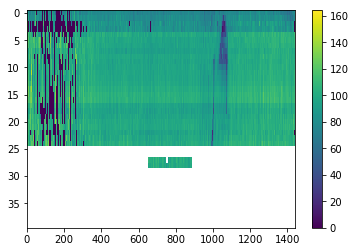

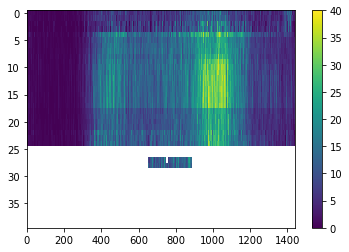

In [23]:
print(speeds.shape)
print(flows.shape)
plt.imshow(speeds, aspect = "auto")
plt.colorbar()
plt.show()
plt.imshow(flows, aspect = "auto")
plt.colorbar()
plt.show()

## Congestion

In [24]:
def parseSpeedFlowsToCongestions(speeds, flows):
    dprint("Starting parseSpeedFlowsToCongestions()")
    congestions = speeds / 50 + flows / 40
    congestions = scipy.ndimage.filters.gaussian_filter(congestions, 3)
    dprint("Ending parseSpeedFlowsToCongestions()")
    return congestions

In [25]:
congestions = parseSpeedFlowsToCongestions(speeds, flows)

2017-11-29 10:59:17 | Starting parseSpeedFlowsToCongestions()
2017-11-29 10:59:17 | Ending parseSpeedFlowsToCongestions()


(40, 1440)


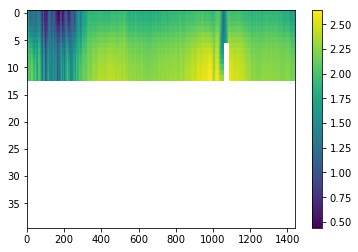

In [26]:
print(congestions.shape)
plt.imshow(congestions, aspect = "auto")
plt.colorbar()
plt.show()

## Congestion Filter

In [27]:
testDataArray = numpy.random.rand(16,9)
print(testDataArray >= 0.9)

[[ True False  True False False False False False False]
 [False False False False False False False False  True]
 [False False False False False False  True False  True]
 [False False False  True False False False False False]
 [False False False False False False  True False False]
 [False False False False  True False False False False]
 [False  True False  True False False False False False]
 [ True False False False False  True False False False]
 [False False False False False False False False False]
 [ True  True  True  True  True False False False False]
 [False False False False False False False False False]
 [False False  True  True False False False False False]
 [False False False False False False  True False False]
 [False False False False False False False False False]
 [False False False False  True False False False False]
 [False False False False False False False False False]]


In [28]:
def addBoundaries(ax, boundaries):
    rect = patches.Rectangle((
        boundaries[2] - 0.5,
        boundaries[0] - 0.5),
        boundaries[3] - boundaries[2] + 1,
        boundaries[1] - boundaries[0] + 1,
        linewidth = 1,
        edgecolor = "r",
        hatch = "//",
        facecolor = "none")
    ax.add_patch(rect)

In [29]:
def showDataWithBoundaries(dataArray, boundariesList):
    fig, ax = plt.subplots(1)
    ax.imshow(dataArray, aspect = "auto")
    for i in range(len(boundariesList)):
        addBoundaries(ax, boundariesList[i])
    plt.show()

In [30]:
def scan(dataArray, boundaries = None, threshold = 1, depth = 0):
    dprint("Starting scan...", depth)
    if boundaries is None:
        boundaries = [0, dataArray.shape[0] - 1, 0, dataArray.shape[1] - 1]
    boundariesList = []
    subArray = dataArray[boundaries[0]:boundaries[1] + 1, boundaries[2]:boundaries[3] + 1]
    arrayBoolean = numpy.any(subArray < threshold, depth % 2)
    if depth % 2:
        length = boundaries[1] + 1 - boundaries[0]
    else:
        length = boundaries[3] + 1 - boundaries[2]
    started = False
    if length > 1:
        childBoundaries = boundaries[:]
        for i in range(length):
            if arrayBoolean[i] and not started:
                dprint("Found start: " + str(i), depth)
                if depth % 2:
                    childBoundaries[0] = boundaries[0] + i
                else:
                    childBoundaries[2] = boundaries[2] + i
                started = True
            elif not arrayBoolean[i] and started:
                dprint("Found stop: " + str(i - 1), depth)
                if depth % 2:
                    childBoundaries[1] = boundaries[0] + i - 1
                else:
                    childBoundaries[3] = boundaries[2] + i - 1
                started = False
                boundariesList.append(childBoundaries[:])
        if started:
            dprint("Found stop at end.", depth)
            if depth % 2:
                childBoundaries[1] = boundaries[1]
            else:
                childBoundaries[3] = boundaries[3]
            boundariesList.append(childBoundaries)
    else:
        dprint("Length is one", depth)
        boundariesList.append(boundaries)
    dprint("Ending scan...", depth)
    return boundariesList

In [31]:
scan(testDataArray, threshold = 0.1, depth = 0)

2017-11-29 10:59:17 | Starting scan...
2017-11-29 10:59:17 | Found start: 0
2017-11-29 10:59:17 | Found stop: 1
2017-11-29 10:59:17 | Found start: 4
2017-11-29 10:59:17 | Found stop at end.
2017-11-29 10:59:17 | Ending scan...


[[0, 15, 0, 1], [0, 15, 4, 8]]

In [32]:
def recursiveScan(dataArray, boundaries = None, depth = 0, parentLength = 0, threshold = 1): # Remove copies?
    dprint("Starting recursiveScan...", depth)
    dprint("Direction: " + str(depth % 2), depth)
    result = []
    boundariesList = scan(dataArray, boundaries, threshold, depth)
    if debugMode:
        showDataWithBoundaries(dataArray, boundariesList)
    length = len(boundariesList)
    dprint("length: " + str(length) + "| parentLength: " + str(parentLength), depth)
    if length == 0:
        dprint("Error: nothing found...", depth) # Throw Exception?
    elif length == 1 and parentLength == 1:
        dprint("Done: " + str(boundariesList[0]))
        return boundariesList
    else:
        dprint("Scanning children...", depth)
        parentLength = length;
        childDepth = depth + 1;
        for i in range(length):
            dprint("Child: " + str(i), depth)
            childBoundaries = boundariesList[i][:]
            result += recursiveScan(dataArray, childBoundaries, childDepth, parentLength, threshold)
    dprint("Ending recursiveScan...", depth)
    return result

2017-11-29 10:59:17 | Starting recursiveScan...
2017-11-29 10:59:17 | Direction: 0
2017-11-29 10:59:17 | Starting scan...
2017-11-29 10:59:17 | Found start: 0
2017-11-29 10:59:17 | Found stop: 1
2017-11-29 10:59:17 | Found start: 4
2017-11-29 10:59:17 | Found stop at end.
2017-11-29 10:59:17 | Ending scan...


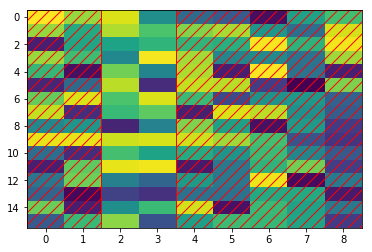

2017-11-29 10:59:17 | length: 2| parentLength: 0
2017-11-29 10:59:17 | Scanning children...
2017-11-29 10:59:17 | Child: 0
  2017-11-29 10:59:17 | Starting recursiveScan...
  2017-11-29 10:59:17 | Direction: 1
  2017-11-29 10:59:17 | Starting scan...
  2017-11-29 10:59:17 | Found start: 2
  2017-11-29 10:59:17 | Found stop: 2
  2017-11-29 10:59:17 | Found start: 4
  2017-11-29 10:59:17 | Found stop: 4
  2017-11-29 10:59:17 | Found start: 11
  2017-11-29 10:59:17 | Found stop: 11
  2017-11-29 10:59:17 | Found start: 13
  2017-11-29 10:59:17 | Found stop: 14
  2017-11-29 10:59:17 | Ending scan...


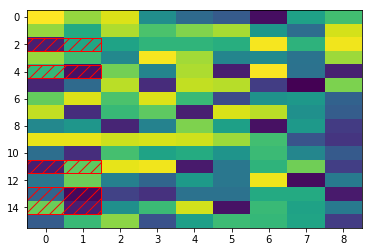

  2017-11-29 10:59:18 | length: 4| parentLength: 2
  2017-11-29 10:59:18 | Scanning children...
  2017-11-29 10:59:18 | Child: 0
    2017-11-29 10:59:18 | Starting recursiveScan...
    2017-11-29 10:59:18 | Direction: 0
    2017-11-29 10:59:18 | Starting scan...
    2017-11-29 10:59:18 | Found start: 0
    2017-11-29 10:59:18 | Found stop: 0
    2017-11-29 10:59:18 | Ending scan...


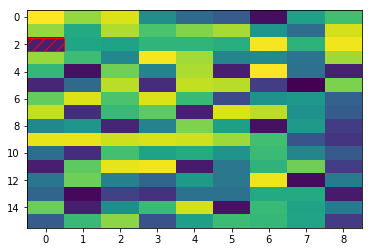

    2017-11-29 10:59:18 | length: 1| parentLength: 4
    2017-11-29 10:59:18 | Scanning children...
    2017-11-29 10:59:18 | Child: 0
      2017-11-29 10:59:18 | Starting recursiveScan...
      2017-11-29 10:59:18 | Direction: 1
      2017-11-29 10:59:18 | Starting scan...
      2017-11-29 10:59:18 | Length is one
      2017-11-29 10:59:18 | Ending scan...


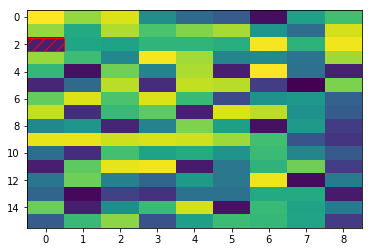

      2017-11-29 10:59:18 | length: 1| parentLength: 1
2017-11-29 10:59:18 | Done: [2, 2, 0, 0]
    2017-11-29 10:59:18 | Ending recursiveScan...
  2017-11-29 10:59:18 | Child: 1
    2017-11-29 10:59:18 | Starting recursiveScan...
    2017-11-29 10:59:18 | Direction: 0
    2017-11-29 10:59:18 | Starting scan...
    2017-11-29 10:59:18 | Found start: 1
    2017-11-29 10:59:18 | Found stop at end.
    2017-11-29 10:59:18 | Ending scan...


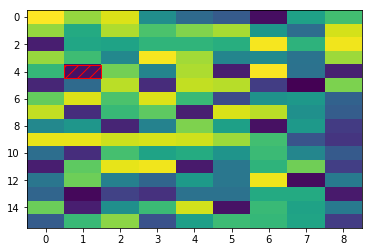

    2017-11-29 10:59:18 | length: 1| parentLength: 4
    2017-11-29 10:59:18 | Scanning children...
    2017-11-29 10:59:18 | Child: 0
      2017-11-29 10:59:18 | Starting recursiveScan...
      2017-11-29 10:59:18 | Direction: 1
      2017-11-29 10:59:18 | Starting scan...
      2017-11-29 10:59:18 | Length is one
      2017-11-29 10:59:18 | Ending scan...


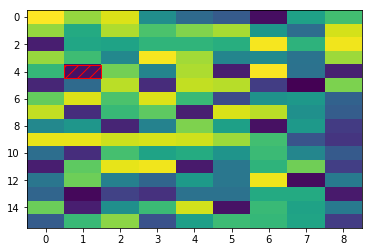

      2017-11-29 10:59:18 | length: 1| parentLength: 1
2017-11-29 10:59:18 | Done: [4, 4, 1, 1]
    2017-11-29 10:59:18 | Ending recursiveScan...
  2017-11-29 10:59:18 | Child: 2
    2017-11-29 10:59:18 | Starting recursiveScan...
    2017-11-29 10:59:18 | Direction: 0
    2017-11-29 10:59:18 | Starting scan...
    2017-11-29 10:59:18 | Found start: 0
    2017-11-29 10:59:18 | Found stop: 0
    2017-11-29 10:59:18 | Ending scan...


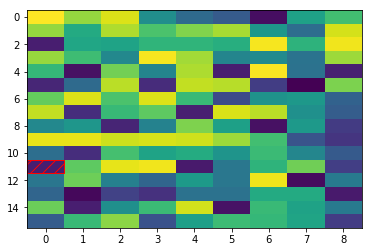

    2017-11-29 10:59:18 | length: 1| parentLength: 4
    2017-11-29 10:59:18 | Scanning children...
    2017-11-29 10:59:18 | Child: 0
      2017-11-29 10:59:18 | Starting recursiveScan...
      2017-11-29 10:59:18 | Direction: 1
      2017-11-29 10:59:18 | Starting scan...
      2017-11-29 10:59:18 | Length is one
      2017-11-29 10:59:18 | Ending scan...


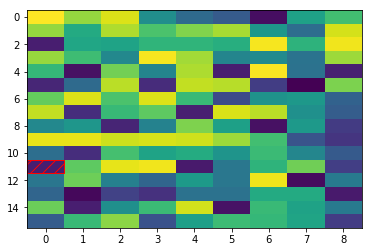

      2017-11-29 10:59:18 | length: 1| parentLength: 1
2017-11-29 10:59:18 | Done: [11, 11, 0, 0]
    2017-11-29 10:59:18 | Ending recursiveScan...
  2017-11-29 10:59:18 | Child: 3
    2017-11-29 10:59:18 | Starting recursiveScan...
    2017-11-29 10:59:18 | Direction: 0
    2017-11-29 10:59:18 | Starting scan...
    2017-11-29 10:59:18 | Found start: 1
    2017-11-29 10:59:18 | Found stop at end.
    2017-11-29 10:59:18 | Ending scan...


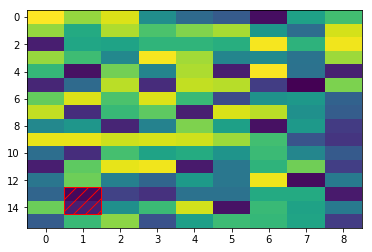

    2017-11-29 10:59:19 | length: 1| parentLength: 4
    2017-11-29 10:59:19 | Scanning children...
    2017-11-29 10:59:19 | Child: 0
      2017-11-29 10:59:19 | Starting recursiveScan...
      2017-11-29 10:59:19 | Direction: 1
      2017-11-29 10:59:19 | Starting scan...
      2017-11-29 10:59:19 | Found start: 0
      2017-11-29 10:59:19 | Found stop at end.
      2017-11-29 10:59:19 | Ending scan...


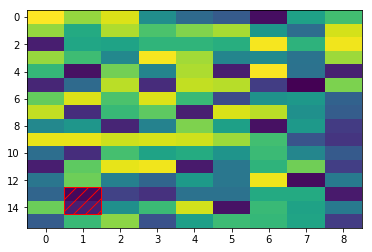

      2017-11-29 10:59:19 | length: 1| parentLength: 1
2017-11-29 10:59:19 | Done: [13, 14, 1, 1]
    2017-11-29 10:59:19 | Ending recursiveScan...
  2017-11-29 10:59:19 | Ending recursiveScan...
2017-11-29 10:59:19 | Child: 1
  2017-11-29 10:59:19 | Starting recursiveScan...
  2017-11-29 10:59:19 | Direction: 1
  2017-11-29 10:59:19 | Starting scan...
  2017-11-29 10:59:19 | Found start: 0
  2017-11-29 10:59:19 | Found stop: 0
  2017-11-29 10:59:19 | Found start: 4
  2017-11-29 10:59:19 | Found stop: 5
  2017-11-29 10:59:19 | Found start: 8
  2017-11-29 10:59:19 | Found stop: 8
  2017-11-29 10:59:19 | Found start: 11
  2017-11-29 10:59:19 | Found stop: 14
  2017-11-29 10:59:19 | Ending scan...


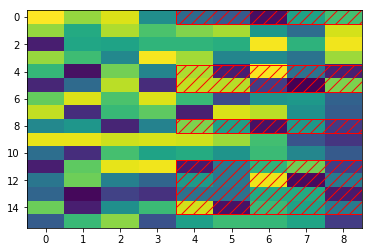

  2017-11-29 10:59:19 | length: 4| parentLength: 2
  2017-11-29 10:59:19 | Scanning children...
  2017-11-29 10:59:19 | Child: 0
    2017-11-29 10:59:19 | Starting recursiveScan...
    2017-11-29 10:59:19 | Direction: 0
    2017-11-29 10:59:19 | Starting scan...
    2017-11-29 10:59:19 | Found start: 2
    2017-11-29 10:59:19 | Found stop: 2
    2017-11-29 10:59:19 | Ending scan...


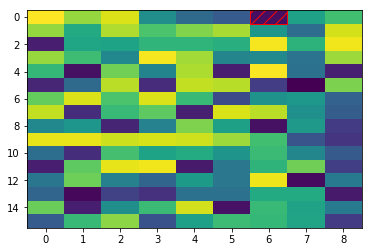

    2017-11-29 10:59:19 | length: 1| parentLength: 4
    2017-11-29 10:59:19 | Scanning children...
    2017-11-29 10:59:19 | Child: 0
      2017-11-29 10:59:19 | Starting recursiveScan...
      2017-11-29 10:59:19 | Direction: 1
      2017-11-29 10:59:19 | Starting scan...
      2017-11-29 10:59:19 | Length is one
      2017-11-29 10:59:19 | Ending scan...


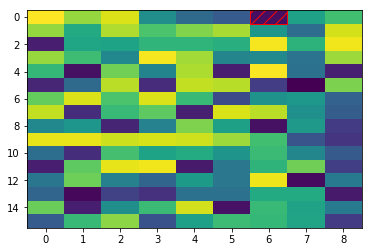

      2017-11-29 10:59:19 | length: 1| parentLength: 1
2017-11-29 10:59:19 | Done: [0, 0, 6, 6]
    2017-11-29 10:59:19 | Ending recursiveScan...
  2017-11-29 10:59:19 | Child: 1
    2017-11-29 10:59:19 | Starting recursiveScan...
    2017-11-29 10:59:19 | Direction: 0
    2017-11-29 10:59:19 | Starting scan...
    2017-11-29 10:59:19 | Found start: 1
    2017-11-29 10:59:19 | Found stop: 1
    2017-11-29 10:59:19 | Found start: 3
    2017-11-29 10:59:19 | Found stop: 3
    2017-11-29 10:59:19 | Ending scan...


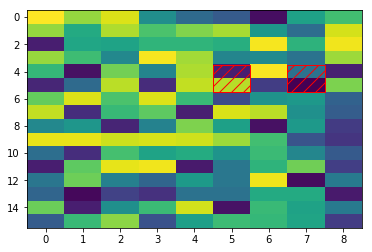

    2017-11-29 10:59:19 | length: 2| parentLength: 4
    2017-11-29 10:59:19 | Scanning children...
    2017-11-29 10:59:19 | Child: 0
      2017-11-29 10:59:19 | Starting recursiveScan...
      2017-11-29 10:59:19 | Direction: 1
      2017-11-29 10:59:19 | Starting scan...
      2017-11-29 10:59:19 | Found start: 0
      2017-11-29 10:59:19 | Found stop: 0
      2017-11-29 10:59:19 | Ending scan...


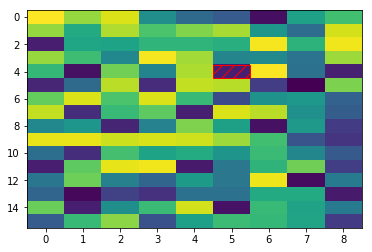

      2017-11-29 10:59:19 | length: 1| parentLength: 2
      2017-11-29 10:59:19 | Scanning children...
      2017-11-29 10:59:19 | Child: 0
        2017-11-29 10:59:19 | Starting recursiveScan...
        2017-11-29 10:59:19 | Direction: 0
        2017-11-29 10:59:19 | Starting scan...
        2017-11-29 10:59:19 | Length is one
        2017-11-29 10:59:19 | Ending scan...


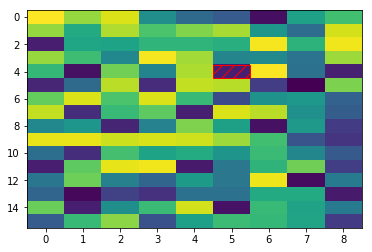

        2017-11-29 10:59:20 | length: 1| parentLength: 1
2017-11-29 10:59:20 | Done: [4, 4, 5, 5]
      2017-11-29 10:59:20 | Ending recursiveScan...
    2017-11-29 10:59:20 | Child: 1
      2017-11-29 10:59:20 | Starting recursiveScan...
      2017-11-29 10:59:20 | Direction: 1
      2017-11-29 10:59:20 | Starting scan...
      2017-11-29 10:59:20 | Found start: 1
      2017-11-29 10:59:20 | Found stop at end.
      2017-11-29 10:59:20 | Ending scan...


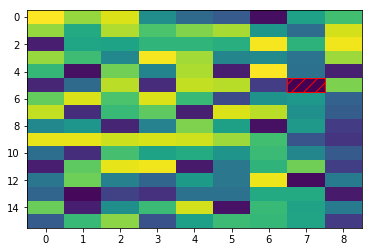

      2017-11-29 10:59:20 | length: 1| parentLength: 2
      2017-11-29 10:59:20 | Scanning children...
      2017-11-29 10:59:20 | Child: 0
        2017-11-29 10:59:20 | Starting recursiveScan...
        2017-11-29 10:59:20 | Direction: 0
        2017-11-29 10:59:20 | Starting scan...
        2017-11-29 10:59:20 | Length is one
        2017-11-29 10:59:20 | Ending scan...


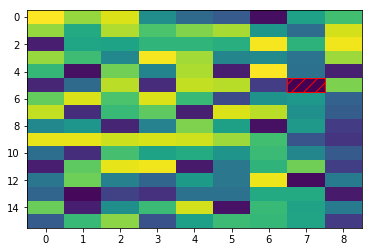

        2017-11-29 10:59:20 | length: 1| parentLength: 1
2017-11-29 10:59:20 | Done: [5, 5, 7, 7]
      2017-11-29 10:59:20 | Ending recursiveScan...
    2017-11-29 10:59:20 | Ending recursiveScan...
  2017-11-29 10:59:20 | Child: 2
    2017-11-29 10:59:20 | Starting recursiveScan...
    2017-11-29 10:59:20 | Direction: 0
    2017-11-29 10:59:20 | Starting scan...
    2017-11-29 10:59:20 | Found start: 2
    2017-11-29 10:59:20 | Found stop: 2
    2017-11-29 10:59:20 | Ending scan...


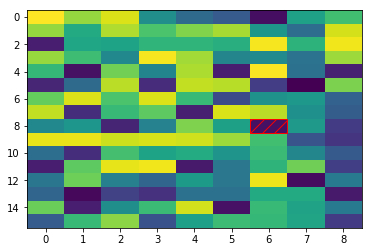

    2017-11-29 10:59:20 | length: 1| parentLength: 4
    2017-11-29 10:59:20 | Scanning children...
    2017-11-29 10:59:20 | Child: 0
      2017-11-29 10:59:20 | Starting recursiveScan...
      2017-11-29 10:59:20 | Direction: 1
      2017-11-29 10:59:20 | Starting scan...
      2017-11-29 10:59:20 | Length is one
      2017-11-29 10:59:20 | Ending scan...


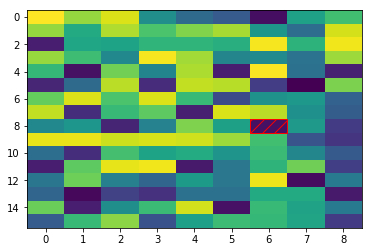

      2017-11-29 10:59:20 | length: 1| parentLength: 1
2017-11-29 10:59:20 | Done: [8, 8, 6, 6]
    2017-11-29 10:59:20 | Ending recursiveScan...
  2017-11-29 10:59:20 | Child: 3
    2017-11-29 10:59:20 | Starting recursiveScan...
    2017-11-29 10:59:20 | Direction: 0
    2017-11-29 10:59:20 | Starting scan...
    2017-11-29 10:59:20 | Found start: 0
    2017-11-29 10:59:20 | Found stop: 1
    2017-11-29 10:59:20 | Found start: 3
    2017-11-29 10:59:20 | Found stop at end.
    2017-11-29 10:59:20 | Ending scan...


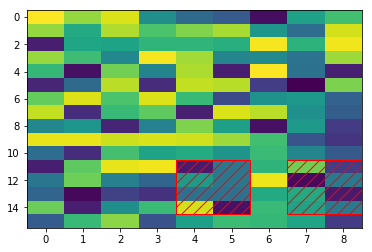

    2017-11-29 10:59:20 | length: 2| parentLength: 4
    2017-11-29 10:59:20 | Scanning children...
    2017-11-29 10:59:20 | Child: 0
      2017-11-29 10:59:20 | Starting recursiveScan...
      2017-11-29 10:59:20 | Direction: 1
      2017-11-29 10:59:20 | Starting scan...
      2017-11-29 10:59:20 | Found start: 0
      2017-11-29 10:59:20 | Found stop: 0
      2017-11-29 10:59:20 | Found start: 3
      2017-11-29 10:59:20 | Found stop at end.
      2017-11-29 10:59:20 | Ending scan...


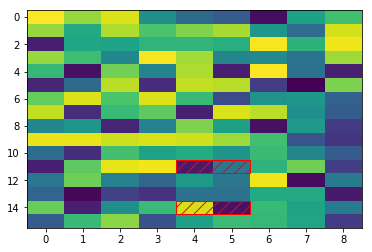

      2017-11-29 10:59:20 | length: 2| parentLength: 2
      2017-11-29 10:59:20 | Scanning children...
      2017-11-29 10:59:20 | Child: 0
        2017-11-29 10:59:20 | Starting recursiveScan...
        2017-11-29 10:59:20 | Direction: 0
        2017-11-29 10:59:20 | Starting scan...
        2017-11-29 10:59:20 | Found start: 0
        2017-11-29 10:59:20 | Found stop: 0
        2017-11-29 10:59:20 | Ending scan...


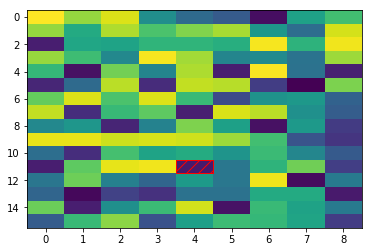

        2017-11-29 10:59:20 | length: 1| parentLength: 2
        2017-11-29 10:59:20 | Scanning children...
        2017-11-29 10:59:20 | Child: 0
          2017-11-29 10:59:20 | Starting recursiveScan...
          2017-11-29 10:59:20 | Direction: 1
          2017-11-29 10:59:20 | Starting scan...
          2017-11-29 10:59:20 | Length is one
          2017-11-29 10:59:20 | Ending scan...


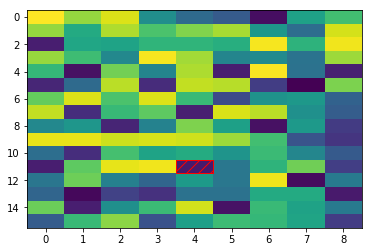

          2017-11-29 10:59:21 | length: 1| parentLength: 1
2017-11-29 10:59:21 | Done: [11, 11, 4, 4]
        2017-11-29 10:59:21 | Ending recursiveScan...
      2017-11-29 10:59:21 | Child: 1
        2017-11-29 10:59:21 | Starting recursiveScan...
        2017-11-29 10:59:21 | Direction: 0
        2017-11-29 10:59:21 | Starting scan...
        2017-11-29 10:59:21 | Found start: 1
        2017-11-29 10:59:21 | Found stop at end.
        2017-11-29 10:59:21 | Ending scan...


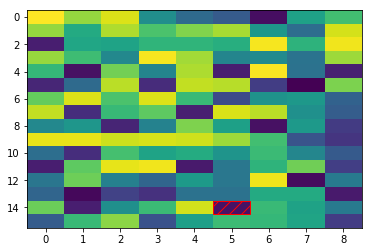

        2017-11-29 10:59:21 | length: 1| parentLength: 2
        2017-11-29 10:59:21 | Scanning children...
        2017-11-29 10:59:21 | Child: 0
          2017-11-29 10:59:21 | Starting recursiveScan...
          2017-11-29 10:59:21 | Direction: 1
          2017-11-29 10:59:21 | Starting scan...
          2017-11-29 10:59:21 | Length is one
          2017-11-29 10:59:21 | Ending scan...


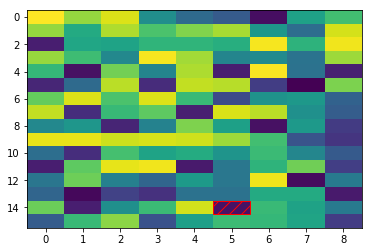

          2017-11-29 10:59:21 | length: 1| parentLength: 1
2017-11-29 10:59:21 | Done: [14, 14, 5, 5]
        2017-11-29 10:59:21 | Ending recursiveScan...
      2017-11-29 10:59:21 | Ending recursiveScan...
    2017-11-29 10:59:21 | Child: 1
      2017-11-29 10:59:21 | Starting recursiveScan...
      2017-11-29 10:59:21 | Direction: 1
      2017-11-29 10:59:21 | Starting scan...
      2017-11-29 10:59:21 | Found start: 1
      2017-11-29 10:59:21 | Found stop: 2
      2017-11-29 10:59:21 | Ending scan...


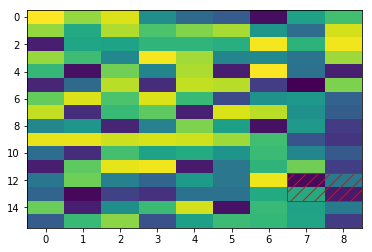

      2017-11-29 10:59:21 | length: 1| parentLength: 2
      2017-11-29 10:59:21 | Scanning children...
      2017-11-29 10:59:21 | Child: 0
        2017-11-29 10:59:21 | Starting recursiveScan...
        2017-11-29 10:59:21 | Direction: 0
        2017-11-29 10:59:21 | Starting scan...
        2017-11-29 10:59:21 | Found start: 0
        2017-11-29 10:59:21 | Found stop at end.
        2017-11-29 10:59:21 | Ending scan...


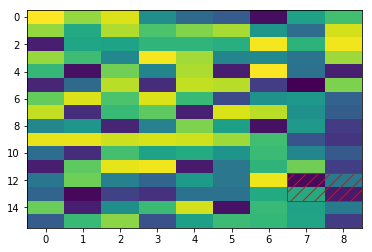

        2017-11-29 10:59:21 | length: 1| parentLength: 1
2017-11-29 10:59:21 | Done: [12, 13, 7, 8]
      2017-11-29 10:59:21 | Ending recursiveScan...
    2017-11-29 10:59:21 | Ending recursiveScan...
  2017-11-29 10:59:21 | Ending recursiveScan...
2017-11-29 10:59:21 | Ending recursiveScan...


In [33]:
testBoundariesList = recursiveScan(testDataArray, threshold = 0.1)

In [34]:
testBoundariesList

[[2, 2, 0, 0],
 [4, 4, 1, 1],
 [11, 11, 0, 0],
 [13, 14, 1, 1],
 [0, 0, 6, 6],
 [4, 4, 5, 5],
 [5, 5, 7, 7],
 [8, 8, 6, 6],
 [11, 11, 4, 4],
 [14, 14, 5, 5],
 [12, 13, 7, 8]]

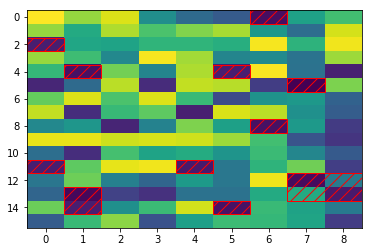

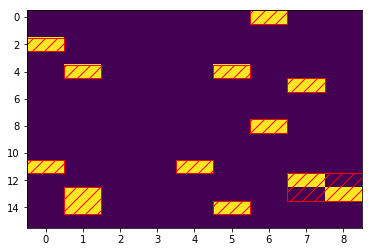

In [35]:
showDataWithBoundaries(testDataArray, testBoundariesList)
showDataWithBoundaries(testDataArray < 0.1, testBoundariesList)

2017-11-29 10:59:22 | Starting recursiveScan...
2017-11-29 10:59:22 | Direction: 0
2017-11-29 10:59:22 | Starting scan...
2017-11-29 10:59:22 | Found start: 77
2017-11-29 10:59:22 | Found stop: 86
2017-11-29 10:59:22 | Found start: 91
2017-11-29 10:59:22 | Found stop: 112
2017-11-29 10:59:22 | Found start: 127
2017-11-29 10:59:22 | Found stop: 137
2017-11-29 10:59:22 | Found start: 150
2017-11-29 10:59:22 | Found stop: 206
2017-11-29 10:59:22 | Found start: 215
2017-11-29 10:59:22 | Found stop: 234
2017-11-29 10:59:22 | Found start: 253
2017-11-29 10:59:22 | Found stop: 257
2017-11-29 10:59:22 | Ending scan...


C:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


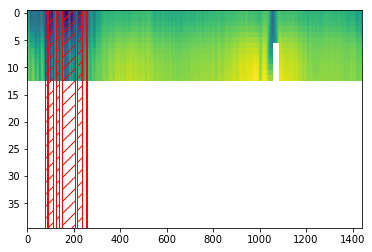

2017-11-29 10:59:22 | length: 6| parentLength: 0
2017-11-29 10:59:22 | Scanning children...
2017-11-29 10:59:22 | Child: 0
  2017-11-29 10:59:22 | Starting recursiveScan...
  2017-11-29 10:59:22 | Direction: 1
  2017-11-29 10:59:22 | Starting scan...
  2017-11-29 10:59:22 | Found start: 0
  2017-11-29 10:59:22 | Found stop: 5
  2017-11-29 10:59:22 | Ending scan...


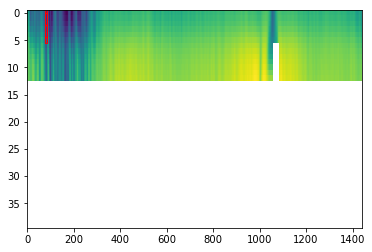

  2017-11-29 10:59:22 | length: 1| parentLength: 6
  2017-11-29 10:59:22 | Scanning children...
  2017-11-29 10:59:22 | Child: 0
    2017-11-29 10:59:22 | Starting recursiveScan...
    2017-11-29 10:59:22 | Direction: 0
    2017-11-29 10:59:22 | Starting scan...
    2017-11-29 10:59:22 | Found start: 0
    2017-11-29 10:59:22 | Found stop at end.
    2017-11-29 10:59:22 | Ending scan...


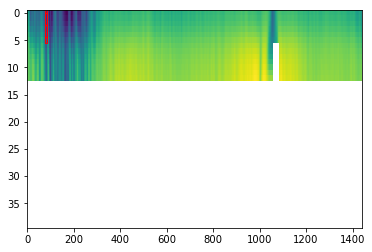

    2017-11-29 10:59:22 | length: 1| parentLength: 1
2017-11-29 10:59:22 | Done: [0, 5, 77, 86]
  2017-11-29 10:59:22 | Ending recursiveScan...
2017-11-29 10:59:22 | Child: 1
  2017-11-29 10:59:22 | Starting recursiveScan...
  2017-11-29 10:59:22 | Direction: 1
  2017-11-29 10:59:22 | Starting scan...
  2017-11-29 10:59:22 | Found start: 0
  2017-11-29 10:59:22 | Found stop: 12
  2017-11-29 10:59:22 | Ending scan...


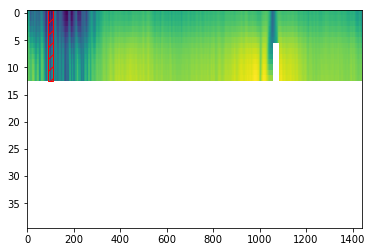

  2017-11-29 10:59:22 | length: 1| parentLength: 6
  2017-11-29 10:59:22 | Scanning children...
  2017-11-29 10:59:22 | Child: 0
    2017-11-29 10:59:22 | Starting recursiveScan...
    2017-11-29 10:59:22 | Direction: 0
    2017-11-29 10:59:22 | Starting scan...
    2017-11-29 10:59:22 | Found start: 0
    2017-11-29 10:59:22 | Found stop at end.
    2017-11-29 10:59:22 | Ending scan...


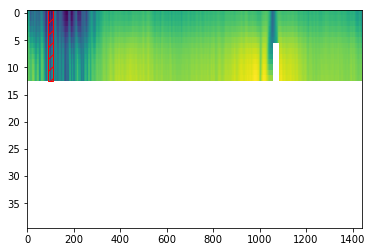

    2017-11-29 10:59:22 | length: 1| parentLength: 1
2017-11-29 10:59:22 | Done: [0, 12, 91, 112]
  2017-11-29 10:59:22 | Ending recursiveScan...
2017-11-29 10:59:22 | Child: 2
  2017-11-29 10:59:22 | Starting recursiveScan...
  2017-11-29 10:59:22 | Direction: 1
  2017-11-29 10:59:22 | Starting scan...
  2017-11-29 10:59:22 | Found start: 0
  2017-11-29 10:59:22 | Found stop: 2
  2017-11-29 10:59:22 | Ending scan...


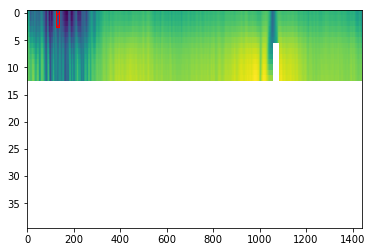

  2017-11-29 10:59:22 | length: 1| parentLength: 6
  2017-11-29 10:59:22 | Scanning children...
  2017-11-29 10:59:22 | Child: 0
    2017-11-29 10:59:22 | Starting recursiveScan...
    2017-11-29 10:59:22 | Direction: 0
    2017-11-29 10:59:22 | Starting scan...
    2017-11-29 10:59:22 | Found start: 0
    2017-11-29 10:59:22 | Found stop at end.
    2017-11-29 10:59:22 | Ending scan...


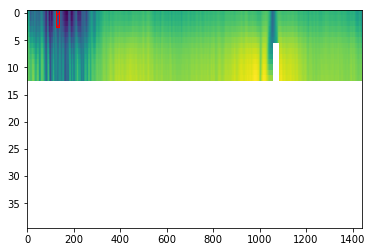

    2017-11-29 10:59:23 | length: 1| parentLength: 1
2017-11-29 10:59:23 | Done: [0, 2, 127, 137]
  2017-11-29 10:59:23 | Ending recursiveScan...
2017-11-29 10:59:23 | Child: 3
  2017-11-29 10:59:23 | Starting recursiveScan...
  2017-11-29 10:59:23 | Direction: 1
  2017-11-29 10:59:23 | Starting scan...
  2017-11-29 10:59:23 | Found start: 0
  2017-11-29 10:59:23 | Found stop: 6
  2017-11-29 10:59:23 | Ending scan...


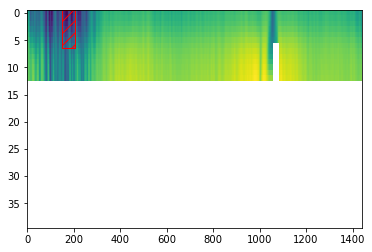

  2017-11-29 10:59:23 | length: 1| parentLength: 6
  2017-11-29 10:59:23 | Scanning children...
  2017-11-29 10:59:23 | Child: 0
    2017-11-29 10:59:23 | Starting recursiveScan...
    2017-11-29 10:59:23 | Direction: 0
    2017-11-29 10:59:23 | Starting scan...
    2017-11-29 10:59:23 | Found start: 0
    2017-11-29 10:59:23 | Found stop at end.
    2017-11-29 10:59:23 | Ending scan...


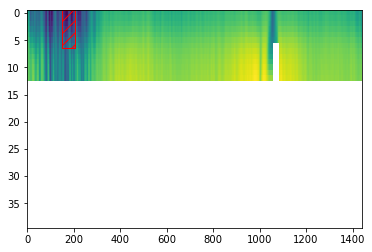

    2017-11-29 10:59:23 | length: 1| parentLength: 1
2017-11-29 10:59:23 | Done: [0, 6, 150, 206]
  2017-11-29 10:59:23 | Ending recursiveScan...
2017-11-29 10:59:23 | Child: 4
  2017-11-29 10:59:23 | Starting recursiveScan...
  2017-11-29 10:59:23 | Direction: 1
  2017-11-29 10:59:23 | Starting scan...
  2017-11-29 10:59:23 | Found start: 0
  2017-11-29 10:59:23 | Found stop: 3
  2017-11-29 10:59:23 | Ending scan...


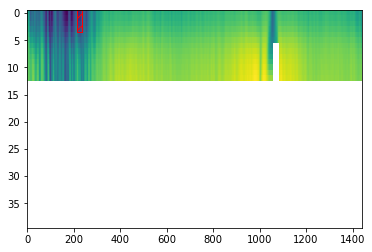

  2017-11-29 10:59:23 | length: 1| parentLength: 6
  2017-11-29 10:59:23 | Scanning children...
  2017-11-29 10:59:23 | Child: 0
    2017-11-29 10:59:23 | Starting recursiveScan...
    2017-11-29 10:59:23 | Direction: 0
    2017-11-29 10:59:23 | Starting scan...
    2017-11-29 10:59:23 | Found start: 0
    2017-11-29 10:59:23 | Found stop at end.
    2017-11-29 10:59:23 | Ending scan...


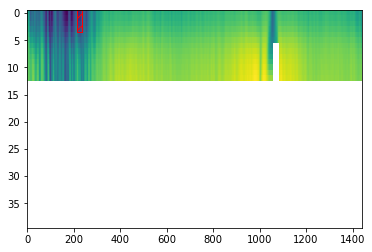

    2017-11-29 10:59:23 | length: 1| parentLength: 1
2017-11-29 10:59:23 | Done: [0, 3, 215, 234]
  2017-11-29 10:59:23 | Ending recursiveScan...
2017-11-29 10:59:23 | Child: 5
  2017-11-29 10:59:23 | Starting recursiveScan...
  2017-11-29 10:59:23 | Direction: 1
  2017-11-29 10:59:23 | Starting scan...
  2017-11-29 10:59:23 | Found start: 0
  2017-11-29 10:59:23 | Found stop: 1
  2017-11-29 10:59:23 | Ending scan...


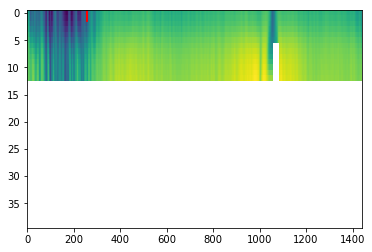

  2017-11-29 10:59:23 | length: 1| parentLength: 6
  2017-11-29 10:59:23 | Scanning children...
  2017-11-29 10:59:23 | Child: 0
    2017-11-29 10:59:23 | Starting recursiveScan...
    2017-11-29 10:59:23 | Direction: 0
    2017-11-29 10:59:23 | Starting scan...
    2017-11-29 10:59:23 | Found start: 0
    2017-11-29 10:59:23 | Found stop at end.
    2017-11-29 10:59:23 | Ending scan...


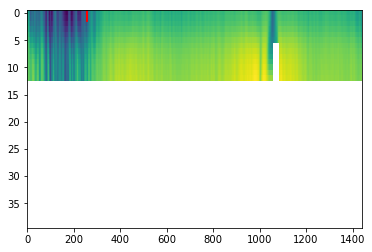

    2017-11-29 10:59:24 | length: 1| parentLength: 1
2017-11-29 10:59:24 | Done: [0, 1, 253, 257]
  2017-11-29 10:59:24 | Ending recursiveScan...
2017-11-29 10:59:24 | Ending recursiveScan...


In [36]:
congestionBoundariesList = recursiveScan(congestions)

In [37]:
congestionBoundariesList

[[0, 5, 77, 86],
 [0, 12, 91, 112],
 [0, 2, 127, 137],
 [0, 6, 150, 206],
 [0, 3, 215, 234],
 [0, 1, 253, 257]]

In [38]:
def addMargins(congestionBoundariesList):
    return congestionBoundariesList

In [39]:
congestionBoundariesList = addMargins(congestionBoundariesList)

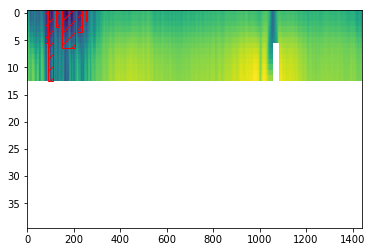

C:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


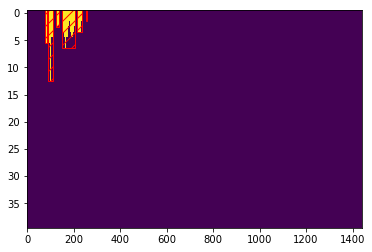

In [40]:
showDataWithBoundaries(congestions, congestionBoundariesList)
showDataWithBoundaries(congestions < 1, congestionBoundariesList)

End of Notebook